<a href="https://colab.research.google.com/github/AmirHoseinTaherkhani/Miros/blob/main/SunspotModel_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [10]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-05-15 08:53:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-05-15 08:53:23 (133 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



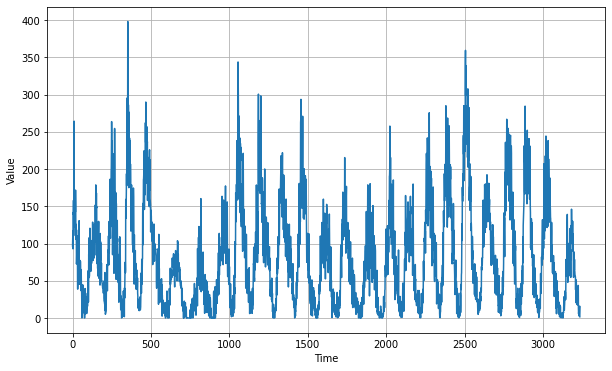

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

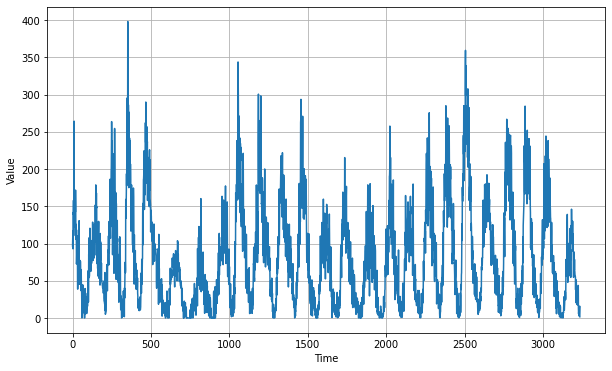

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 34s 31ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 0s 27ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 0s 27ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 0s 28ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 0s 27ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 0s 30ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 0s 30ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 0s 29ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

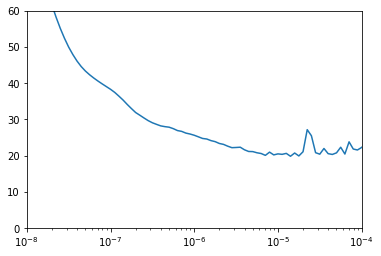

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 29ms/step - loss: 47.7134 - mae: 48.2106
Epoch 2/500
30/30 [==============================] - 1s 15ms/step - loss: 26.8675 - mae: 27.3624
Epoch 3/500
30/30 [==============================] - 1s 15ms/step - loss: 22.9760 - mae: 23.4705
Epoch 4/500
30/30 [==============================] - 1s 15ms/step - loss: 20.2693 - mae: 20.7624
Epoch 5/500
30/30 [==============================] - 1s 15ms/step - loss: 19.3876 - mae: 19.8801
Epoch 6/500
30/30 [==============================] - 1s 15ms/step - loss: 19.3047 - mae: 19.7969
Epoch 7/500
30/30 [==============================] - 1s 16ms/step - loss: 18.4788 - mae: 18.9704
Epoch 8/500
30/30 [==============================] - 1s 16ms/step - loss: 17.9487 - mae: 18.4399
Epoch 9/500
30/30 [==============================] - 1s 15ms/step - loss: 17.9746 - mae: 18.4655
Epoch 10/500
30/30 [==============================] - 1s 16ms/step - loss: 19.0895 - mae: 19.5813
Epoch 11/500
30/30 [=========

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

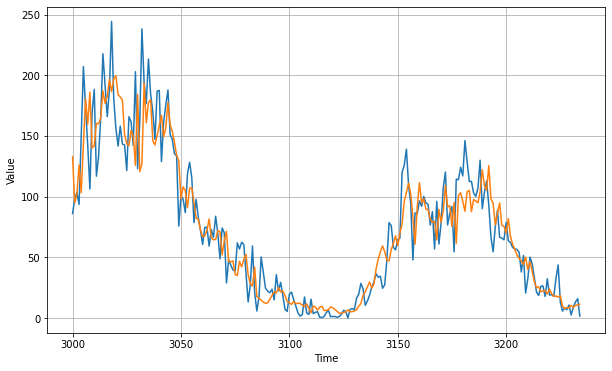

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.183876

<Figure size 432x288 with 0 Axes>

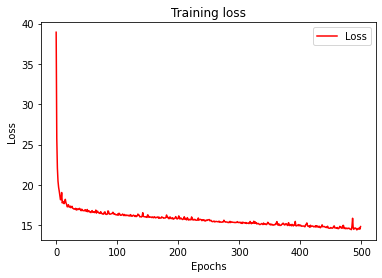

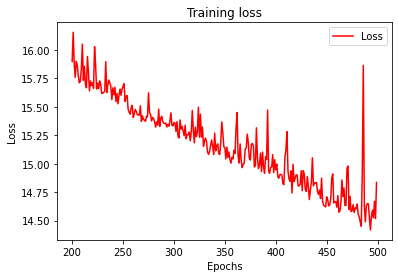

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[132.98686    94.7898    101.94159   125.92894   103.155685  143.1742
 180.52284   159.61171   186.17111   140.09306   141.71481   160.38947
 160.03404   164.62854   187.08957   176.84714   182.62675   196.56755
 186.38017   196.88792   199.54713   183.89188   182.1165    179.4035
 151.08775   143.61134   141.90622   154.48099   149.69312   125.7683
 184.13618   120.642265  127.13679   193.316     160.8158    177.45947
 179.81602   145.95476   142.5533    150.59521   158.2888    167.12457
 149.25742   156.46552   177.36943   159.14822   153.75597   144.70227
 134.08875   129.56015    98.244835  108.02788   105.04029    90.9424
 106.96008   107.166794   95.15173    82.148346   81.26912    72.61102
  66.832306   67.81235    72.07395    81.506516   66.19296    64.42509
  64.68704    71.81439    71.18022    51.92747    63.82086    71.39729
  46.617313   46.338905   46.98203    35.877243   34.91175    46.68647
  42.070312   48.29297    52.507633   35.43301    28.41148    26.336067
  41.9190